In [1]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
## for processing
import re
import nltk
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for w2v
import gensim
import gensim.downloader as gensim_api
## for bert
import transformers
import pandas as pd
import tarfile
import os
import gc
import random

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D,Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows',5000)
from tqdm.autonotebook import tqdm
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
import pandas as pd

# Charger les données
data = pd.read_csv("/kaggle/input/red-3k/REDbySFR.csv", sep=';', header=0)

data= data.drop('Unnamed: 0',axis=1)

# data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head(5)

,Date,Review,Rating
0,05/05/2023,"A FUIR !!!!!!!!!!!!!!!\nTrès mécontente, après avoir attendu 6 heures le technicien (dans un appartement loin de chez moi où je ne pouvais rien faire, et ayant dû poser ma journée) personne n'est venu, on m'a promis un dédommagement au téléphone et maintenant ils disent qu'il n'y a pas d'écrit et que cela fait plus de deux mois (j'ai relancé entre temps 2 fois !).... ULTRA mécontente, une vraie ARNAQUE !",1
1,05/05/2023,"Prise de rdv pour une installation fibre chez ma grand-mère. Le technicien refuse d'acheminer le câble où elle lui demande en prétextant des impossibilités techniques, n'en fait qu'à sa tête et creuse un trou dans la terrasse pour faire passer le câble. Ma mère est obligée d'intervenir et lui demande de tout arrêter. Il s'en va. Nouvelle prise de rendez-vous, nous demandons à changer de sous-traitant. Le rdv est pris pour un autre matin. Puis ce matin là à 9h, il est déplacé pour 13h et finalement le technicien ne viendra pas. Le rendez-vous est alors reporté au lendemain après-midi et une conseillère me planifie un rdv téléphonique à la suite de ce rdv (elle ne l'a bien sûr pas honoré). Finalement c'est le même sous-traitant, mais un technicien plus expérimenté. Il rebouche le trou (bien sur pas la bonne couleur). L'installation se passe bien.\n1 journée et demie de perdu (= congés sans soldes), 1 terrasse détériorée.\nJe demande un dédommagement pour tout cela.\nOn me propose un mois gratuit. Soit 10% de la somme que ça a engendré en frais annexe.\nRien de plus, à peine des excuses, la conseillère absolument pas empathique ou sympathique, même pas de bonne journée en fin d'appel.\nÉvidemment pour arriver à avoir cette personne je suis passée par au moins 10 interlocuteurs.\nJe suis dégoutée par ce traitement. Je suis dégoutée par SFR qui impose un certains nombre d'interventions à ses sous-traitants et par conséquent qu'ils ne peuvent pas honorés leurs rendez-vous. Je suis dégoutée du mépris du 1er technicien envers ma grand-mère.\nPour l'instant le téléphone ne fonctionne toujours pas car le câble tel est différent entre l'ADSL et la fibre mais ça ce n'est rien par rapport au reste...",1
2,02/05/2023,"Nous n'arrivions pas à faire changer notre connect tv auprès du service client qui disfonctionnait. Au bout de 3 mois nous avons réussi et ils ont envoyé le matériel à notre ancienne adresse...! Après ça, les problèmes de la Connect tv étaient les mêmes... nous avons dû acheter notre propre matériel.",1
3,01/05/2023,Je suis partie vivre à l’étranger. J’ai donc retiré ma carte SIM de mon téléphone. J’ai reçu des factures de téléphone avec du hors forfait. Je souligne bien que ma puce n’était même pas dans mon téléphone. À boycotter SFR ! Des voleurs !,1
4,21/04/2023,"Zéro étoile j’ai résilié une option netflix depuis 20 février 2022 et on me prélève toujours on est le 21/04/2023 sois disant sans engament. Oui je suis d’accord avec les autre avis des gros voleurs et leur service clients déplorables qui touche un salaire et vous font croire qui vont resoudre le problème, il sont entrain de couler l’entreprise, fuyez pauvre fou.",1


In [3]:
data.shape

(3015, 3)

In [4]:
import re
import string
import nltk
from nltk.corpus import stopwords

def preprocess_customer_feedback(text):
    # Convertir en minuscules
    text = text.lower()

    # Supprimer les caractères spéciaux et les emojis
#     text = emoji.demojize(text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r':[a-z_]+:', ' ', text)

    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenisation
    tokens = text.split()

    # Supprimer les stopwords
    stop_words = set(stopwords.words('french'))
    tokens = [token for token in tokens if token not in stop_words]

#     # Lemmatisation avec spaCy
#     doc = nlp(text)
#     tokens = [token.lemma_ for token in doc]

#     # Stemming
#     stemmer = SnowballStemmer("french")
#     tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

In [5]:
labels = {"Résiliation": ["resilié","résiliée","résiliation","resiliation","résilier"],
          "ImageDeMarque" : ["opérateur", "catastrophe", "voleur","menteur","fuir", "arnaque", "concurrent","orange","free","cette entreprise","fuyez","Commerciaux","Publicité", "mensongère",'satisfait'],
          "ServiceClient": [ "conseiller", "compétent","professionnalisme","chatbot","coup de fil","raccroché","raccroche","chat","messagerie","visuelle","vocale","répond","répondre","après vente","service après vente","rappeler","conseiller","incompétents","service clients","accueil","service client", "assistance", "hotline", "support", "aide", "conseiller", "conseil","sav","commercial","appelle","joindre","harcelement","Réception","service","Injoignable","rendez vous","client","Réception","reclame"],
          "Forfait/Offre": ["abonnement","annonces" ,"publicitaires","forfait","promo","promotion", "offre", "rabais", "réduction", "avantage", "bon plan", "code promo","abonnement","remise","inscription"],
          "Facturation": ["débitée","tarification","surfacturation","facturation","facture","débité", "paiement", "montant", "échéance", "remboursement","prélèvement", "tva","augmentation de prix",'Remboursez',"payer",'tarif',"facturé","remboursent"],
          "Débit/Internet": ["fibre","fibre optique","internet","vitesse", "débit", "connexion", "lenteur", "ralentissement", "instabilité", "buffering","déconnecte"],
          "Installation/ServiceTechnique": ["tech","rdv","rendez-vous","Service Technique","Technicien","installation", "paramétrage", "configuration", "réglage", "installation", "paramètre", "logiciel"],
          "Contrat": ["contrat","engagement", "durée", "renouvellement", "engager", "souscrire", "clause","contrats"],
          "Couverture/Réseau": ["coupure","couverture","réseau", "câble", "antenne", "télévision", "wifi", "téléphone", "signal"]}

In [6]:
def preprocess_labels(labels_dict):
    preprocessed_labels = {}
    for key, value_list in labels_dict.items():
        preprocessed_values = [preprocess_customer_feedback(value) for value in value_list]
        preprocessed_labels[key] = preprocessed_values
    return preprocessed_labels

In [7]:
labels = preprocess_labels(labels)
print(labels)

{'Résiliation': ['resilié', 'résiliée', 'résiliation', 'resiliation', 'résilier'], 'ImageDeMarque': ['opérateur', 'catastrophe', 'voleur', 'menteur', 'fuir', 'arnaque', 'concurrent', 'orange', 'free', 'cette entreprise', 'fuyez', 'commerciaux', 'publicité', 'mensongère', 'satisfait'], 'ServiceClient': ['conseiller', 'compétent', 'professionnalisme', 'chatbot', 'coup fil', 'raccroché', 'raccroche', 'chat', 'messagerie', 'visuelle', 'vocale', 'répond', 'répondre', 'après vente', 'service après vente', 'rappeler', 'conseiller', 'incompétents', 'service clients', 'accueil', 'service client', 'assistance', 'hotline', 'support', 'aide', 'conseiller', 'conseil', 'sav', 'commercial', 'appelle', 'joindre', 'harcelement', 'réception', 'service', 'injoignable', 'rendez', 'client', 'réception', 'reclame'], 'Forfait/Offre': ['abonnement', 'annonces', 'publicitaires', 'forfait', 'promo', 'promotion', 'offre', 'rabais', 'réduction', 'avantage', 'bon plan', 'code promo', 'abonnement', 'remise', 'inscr

In [8]:
data['Review_cleaned'] = data['Review'].apply(preprocess_customer_feedback)

In [9]:
    def get_categories(text):
        category_votes = {}
        for category, keywords in labels.items():
            for keyword in keywords:
                if keyword in text.lower():
                    if category in category_votes:
                        category_votes[category] += 1
                    else:
                        category_votes[category] = 1
        categories = sorted(category_votes, key=category_votes.get, reverse=True)[:3]
        categories = list(set(categories))
        if len(categories) == 3 and category_votes[categories[2]] == category_votes[categories[1]]:
            categories = categories[:2]
        return categories

    data["categories"] = data["Review_cleaned"].apply(get_categories)

    # Créer trois nouvelles colonnes pour les catégories
    data["categorie1"] = None
    data["categorie2"] = None
    data["categorie3"] = None

    # Remplir les colonnes des catégories avec les noms des catégories
    for index, row in data.iterrows():
        categories = row["categories"]
        for i in range(len(categories)):
            data.at[index, f'categorie{i+1}'] = categories[i]

In [10]:
data["categories"] = data["Review_cleaned"].apply(get_categories)

In [11]:
data.head(2)

,Date,Review,Rating,Review_cleaned,categories,categorie1,categorie2,categorie3
0,05/05/2023,"A FUIR !!!!!!!!!!!!!!!\nTrès mécontente, après avoir attendu 6 heures le technicien (dans un appartement loin de chez moi où je ne pouvais rien faire, et ayant dû poser ma journée) personne n'est venu, on m'a promis un dédommagement au téléphone et maintenant ils disent qu'il n'y a pas d'écrit et que cela fait plus de deux mois (j'ai relancé entre temps 2 fois !).... ULTRA mécontente, une vraie ARNAQUE !",1,a fuir très mécontente après avoir attendu 6 heures technicien appartement loin chez où pouvais rien faire dû poser journée personne venu a promis dédommagement téléphone maintenant disent a écrit cela fait plus deux mois relancé entre temps 2 fois ultra mécontente vraie arnaque,"[Installation/ServiceTechnique, ImageDeMarque, Couverture/Réseau]",Installation/ServiceTechnique,ImageDeMarque,Couverture/Réseau
1,05/05/2023,"Prise de rdv pour une installation fibre chez ma grand-mère. Le technicien refuse d'acheminer le câble où elle lui demande en prétextant des impossibilités techniques, n'en fait qu'à sa tête et creuse un trou dans la terrasse pour faire passer le câble. Ma mère est obligée d'intervenir et lui demande de tout arrêter. Il s'en va. Nouvelle prise de rendez-vous, nous demandons à changer de sous-traitant. Le rdv est pris pour un autre matin. Puis ce matin là à 9h, il est déplacé pour 13h et finalement le technicien ne viendra pas. Le rendez-vous est alors reporté au lendemain après-midi et une conseillère me planifie un rdv téléphonique à la suite de ce rdv (elle ne l'a bien sûr pas honoré). Finalement c'est le même sous-traitant, mais un technicien plus expérimenté. Il rebouche le trou (bien sur pas la bonne couleur). L'installation se passe bien.\n1 journée et demie de perdu (= congés sans soldes), 1 terrasse détériorée.\nJe demande un dédommagement pour tout cela.\nOn me propose un mois gratuit. Soit 10% de la somme que ça a engendré en frais annexe.\nRien de plus, à peine des excuses, la conseillère absolument pas empathique ou sympathique, même pas de bonne journée en fin d'appel.\nÉvidemment pour arriver à avoir cette personne je suis passée par au moins 10 interlocuteurs.\nJe suis dégoutée par ce traitement. Je suis dégoutée par SFR qui impose un certains nombre d'interventions à ses sous-traitants et par conséquent qu'ils ne peuvent pas honorés leurs rendez-vous. Je suis dégoutée du mépris du 1er technicien envers ma grand-mère.\nPour l'instant le téléphone ne fonctionne toujours pas car le câble tel est différent entre l'ADSL et la fibre mais ça ce n'est rien par rapport au reste...",1,prise rdv installation fibre chez grand mère technicien refuse acheminer câble où demande prétextant impossibilités techniques fait tête creuse trou terrasse faire passer câble mère obligée intervenir demande tout arrêter va nouvelle prise rendez demandons changer sous traitant rdv pris autre matin puis matin là 9h déplacé 13h finalement technicien viendra rendez alors reporté lendemain après midi conseillère planifie rdv téléphonique suite rdv a bien sûr honoré finalement sous traitant technicien plus expérimenté rebouche trou bien bonne couleur installation passe bien 1 journée demie perdu congés sans soldes 1 terrasse détériorée demande dédommagement tout cela propose mois gratuit 10 somme ça a engendré frais annexe rien plus peine excuses conseillère absolument empathique sympathique bonne journée fin appel évidemment arriver avoir cette personne passée moins 10 interlocuteurs dégoutée traitement dégoutée sfr impose certains nombre interventions sous traitants conséquent peuvent honorés leurs rendez dégoutée mépris 1er technicien envers grand mère instant téléphone fonctionne toujours car câble tel différent entre adsl fibre ça rien rapport reste,"[Installation/ServiceTechnique, ServiceClient]",Installation/ServiceTechnique,ServiceClient,None


In [12]:
data.categorie1.value_counts()

ServiceClient                    2048
ImageDeMarque                    265 
Facturation                      253 
Installation/ServiceTechnique    173 
Forfait/Offre                    89  
Couverture/Réseau                51  
Débit/Internet                   34  
Contrat                          24  
Résiliation                      8   
Name: categorie1, dtype: int64

In [13]:
data[data.categories == ''].shape

(0, 8)

In [14]:
data['Review'] = data['Review'].str.replace('\n', ' ')
data['Review'] = data['Review'].str.replace(',', ' ')

In [15]:
data['Review_cleaned'] = data['Review_cleaned'].str.replace('\n', ' ')
data['Review_cleaned'] = data['Review_cleaned'].str.replace(',', ' ')

In [16]:
data.to_csv('key_words_0805.csv')

# Vis : Number of reviews per category

In [17]:
data['Date'] = pd.to_datetime(data['Date'])

In [18]:
start_date = '2021-02-02'
end_date = '2023-05-05'
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

In [19]:
melted_data = filtered_data.melt(id_vars=['Review', 'Date'], value_vars=['categorie1', 'categorie2', 'categorie3'], var_name='category', value_name='categories')

In [20]:
melted_data = melted_data[melted_data['categories'].notnull()]

In [21]:
category_counts = melted_data.groupby('categories')['Review'].count().reset_index()

In [22]:
category_counts = category_counts.sort_values(by='Review', ascending=False)

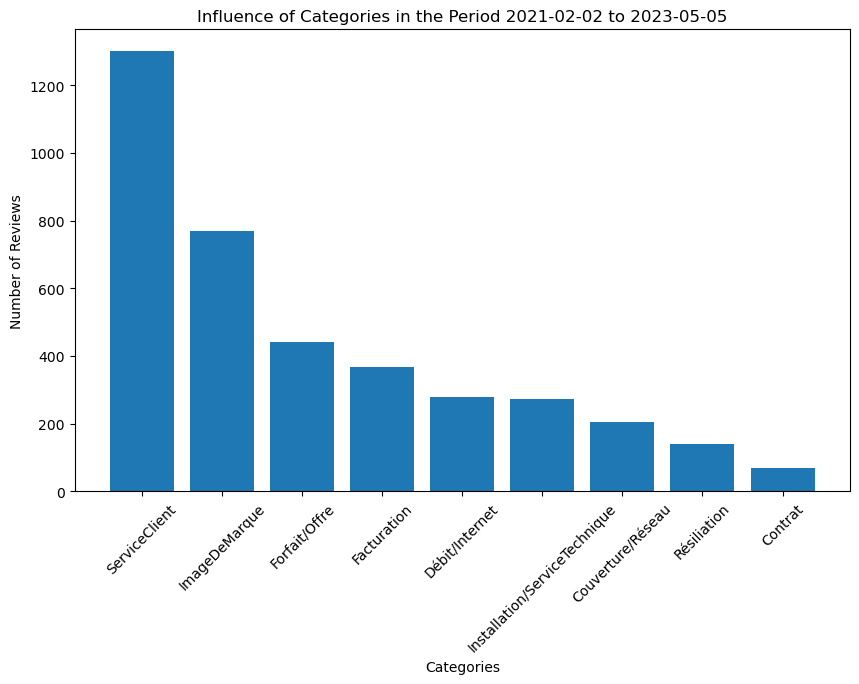

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(category_counts['categories'], category_counts['Review'])
plt.xlabel('Categories')
plt.ylabel('Number of Reviews')
plt.title('Influence of Categories in the Period 2021-02-02 to 2023-05-05')
plt.xticks(rotation=45)
plt.show()

# Vis : Waterfall 3 Categories/Trimestre 

In [24]:
data['Date'] = pd.to_datetime(data['Date'])
data['quarter'] = data['Date'].dt.to_period('Q')

In [25]:
quarterly_data = data.groupby(['quarter', 'categorie1', 'categorie2', 'categorie3']).size().reset_index(name='count')

In [26]:
import pandas as pd
import plotly.graph_objs as go


quarters = sorted(quarterly_data['quarter'].unique())
fig = go.Figure()

for i, quarter in enumerate(quarters):
    quarter_data = quarterly_data[quarterly_data['quarter'] == quarter]
    categories = quarter_data[['categorie1', 'categorie2', 'categorie3']].values.tolist()

    # Créez une liste pour contenir les noms des catégories
    category_labels = [' / '.join(cat) for cat in categories]

    fig.add_trace(go.Waterfall(
        name=f"{quarter}",
        orientation="v",
        measure=["relative" for _ in range(len(quarter_data))] + ["total"],
        x=[f"{label} ({quarter})" for label in category_labels] + [f"Total ({quarter})"],
        textposition="inside",
        text=["+{0:.0f}".format(c) for c in quarter_data['count']] + [""],
        y=quarter_data['count'].tolist() + [0],
        connector={"line": {"color": "rgb(63, 63, 63)"}},
    ))

fig.update_layout(
    title="Waterfall graph pour chaque trimestre",
    showlegend=True,
    xaxis_title="Catégories",
    yaxis_title="Nombre de reviews",
    plot_bgcolor="rgba(240, 240, 240, 0.95)",
    paper_bgcolor="rgba(240, 240, 240, 0.95)",
)

fig.show()

# Vis : Waterfall pour chaque categorie dominante / année 

In [27]:
data['year'] = data['Date'].dt.to_period('Y')

In [28]:
yearly_data = data.groupby(['year', 'categorie1']).size().reset_index(name='count')

In [29]:
unique_categories = sorted(yearly_data['categorie1'].unique())

for category in unique_categories:
    fig = go.Figure()

    category_data = yearly_data[yearly_data['categorie1'] == category]

    fig.add_trace(go.Waterfall(
        name="Nombre de reviews",
        orientation="v",
        measure=["relative" for _ in range(len(category_data))],
        x=category_data['year'].astype(str),
        textposition="inside",
        text=["+{0:.0f}".format(c) for c in category_data['count']],
        y=category_data['count'],
        connector={"line": {"color": "rgb(63, 63, 63)"}},
    ))

    fig.update_layout(
        title=f"Waterfall graph pour la catégorie1: {category}",
        showlegend=False,
        xaxis_title="Années",
        yaxis_title="Nombre de reviews",
        plot_bgcolor="rgba(240, 240, 240, 0.95)",
        paper_bgcolor="rgba(240, 240, 240, 0.95)",
    )

    fig.show()

# Vis : Waterfall graphe de la categorie dominante depuis l'année 2017 jusqu'à 2023

In [30]:
years = sorted(yearly_data['year'].unique())

fig = go.Figure()

for year in years:
    year_data = yearly_data[yearly_data['year'] == year]
    category_labels = year_data['categorie1'].unique()

    fig.add_trace(go.Waterfall(
        name=f"{year}",
        orientation="v",
        measure=["relative" for _ in range(len(year_data))] + ["total"],
        x=list(category_labels) + [f"Total ({year})"],
        textposition="inside",
        text=["+{0:.0f}".format(c) for c in year_data['count']] + [""],
        y=year_data['count'].tolist() + [0],
        connector={"line": {"color": "rgb(63, 63, 63)"}},
    ))

fig.update_layout(
    title="Waterfall graph cumulatif pour la catégorie1 pour chaque année",
    showlegend=True,
    xaxis_title="Catégorie1",
    yaxis_title="Nombre de reviews",
    plot_bgcolor="rgba(240, 240, 240, 0.95)",
    paper_bgcolor="rgba(240, 240, 240, 0.95)",
)

fig.show()

In [31]:
data.head(2)

,Date,Review,Rating,Review_cleaned,categories,categorie1,categorie2,categorie3,quarter,year
0,2023-05-05,A FUIR !!!!!!!!!!!!!!! Très mécontente après avoir attendu 6 heures le technicien (dans un appartement loin de chez moi où je ne pouvais rien faire et ayant dû poser ma journée) personne n'est venu on m'a promis un dédommagement au téléphone et maintenant ils disent qu'il n'y a pas d'écrit et que cela fait plus de deux mois (j'ai relancé entre temps 2 fois !).... ULTRA mécontente une vraie ARNAQUE !,1,a fuir très mécontente après avoir attendu 6 heures technicien appartement loin chez où pouvais rien faire dû poser journée personne venu a promis dédommagement téléphone maintenant disent a écrit cela fait plus deux mois relancé entre temps 2 fois ultra mécontente vraie arnaque,"[Installation/ServiceTechnique, ImageDeMarque, Couverture/Réseau]",Installation/ServiceTechnique,ImageDeMarque,Couverture/Réseau,2023Q2,2023
1,2023-05-05,Prise de rdv pour une installation fibre chez ma grand-mère. Le technicien refuse d'acheminer le câble où elle lui demande en prétextant des impossibilités techniques n'en fait qu'à sa tête et creuse un trou dans la terrasse pour faire passer le câble. Ma mère est obligée d'intervenir et lui demande de tout arrêter. Il s'en va. Nouvelle prise de rendez-vous nous demandons à changer de sous-traitant. Le rdv est pris pour un autre matin. Puis ce matin là à 9h il est déplacé pour 13h et finalement le technicien ne viendra pas. Le rendez-vous est alors reporté au lendemain après-midi et une conseillère me planifie un rdv téléphonique à la suite de ce rdv (elle ne l'a bien sûr pas honoré). Finalement c'est le même sous-traitant mais un technicien plus expérimenté. Il rebouche le trou (bien sur pas la bonne couleur). L'installation se passe bien. 1 journée et demie de perdu (= congés sans soldes) 1 terrasse détériorée. Je demande un dédommagement pour tout cela. On me propose un mois gratuit. Soit 10% de la somme que ça a engendré en frais annexe. Rien de plus à peine des excuses la conseillère absolument pas empathique ou sympathique même pas de bonne journée en fin d'appel. Évidemment pour arriver à avoir cette personne je suis passée par au moins 10 interlocuteurs. Je suis dégoutée par ce traitement. Je suis dégoutée par SFR qui impose un certains nombre d'interventions à ses sous-traitants et par conséquent qu'ils ne peuvent pas honorés leurs rendez-vous. Je suis dégoutée du mépris du 1er technicien envers ma grand-mère. Pour l'instant le téléphone ne fonctionne toujours pas car le câble tel est différent entre l'ADSL et la fibre mais ça ce n'est rien par rapport au reste...,1,prise rdv installation fibre chez grand mère technicien refuse acheminer câble où demande prétextant impossibilités techniques fait tête creuse trou terrasse faire passer câble mère obligée intervenir demande tout arrêter va nouvelle prise rendez demandons changer sous traitant rdv pris autre matin puis matin là 9h déplacé 13h finalement technicien viendra rendez alors reporté lendemain après midi conseillère planifie rdv téléphonique suite rdv a bien sûr honoré finalement sous traitant technicien plus expérimenté rebouche trou bien bonne couleur installation passe bien 1 journée demie perdu congés sans soldes 1 terrasse détériorée demande dédommagement tout cela propose mois gratuit 10 somme ça a engendré frais annexe rien plus peine excuses conseillère absolument empathique sympathique bonne journée fin appel évidemment arriver avoir cette personne passée moins 10 interlocuteurs dégoutée traitement dégoutée sfr impose certains nombre interventions sous traitants conséquent peuvent honorés leurs rendez dégoutée mépris 1er technicien envers grand mère instant téléphone fonctionne toujours car câble tel différent entre adsl fibre ça rien rapport reste,"[Installation/ServiceTechnique, ServiceClient]",Installation/ServiceTechnique,ServiceClient,None,2023Q2,2023


# Vis : Graphe pour analyse temporelle des avis client selon leur ratings

In [32]:
data['Date'] = pd.to_datetime(data['Date'])

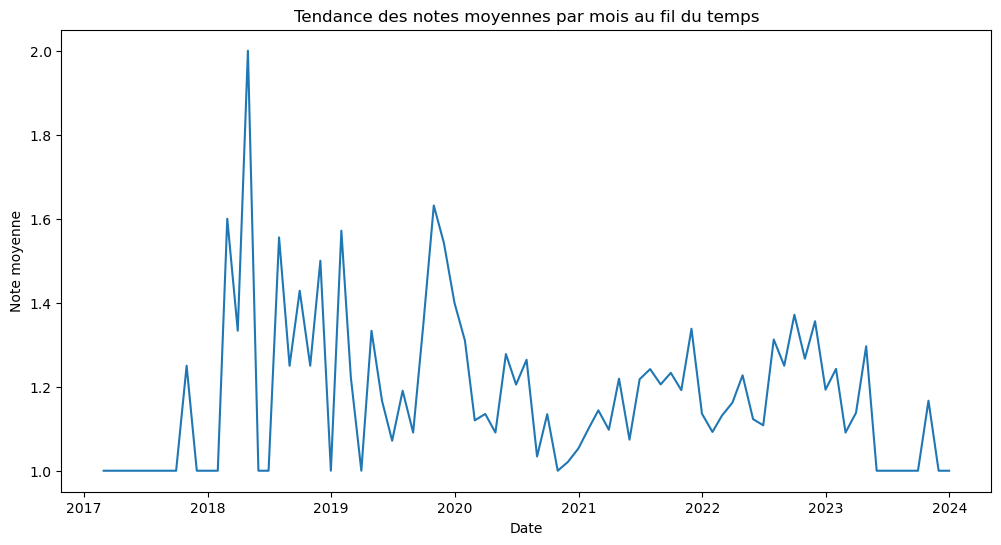

In [33]:
# Groupez les données par mois (ou trimestre) et calculez la note moyenne
monthly_data = data.resample('M', on='Date').mean()

# Créez le graphique en courbes
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_data.index, y=monthly_data['Rating'])
plt.title('Tendance des notes moyennes par mois au fil du temps')
plt.xlabel('Date')
plt.ylabel('Note moyenne')
plt.show()

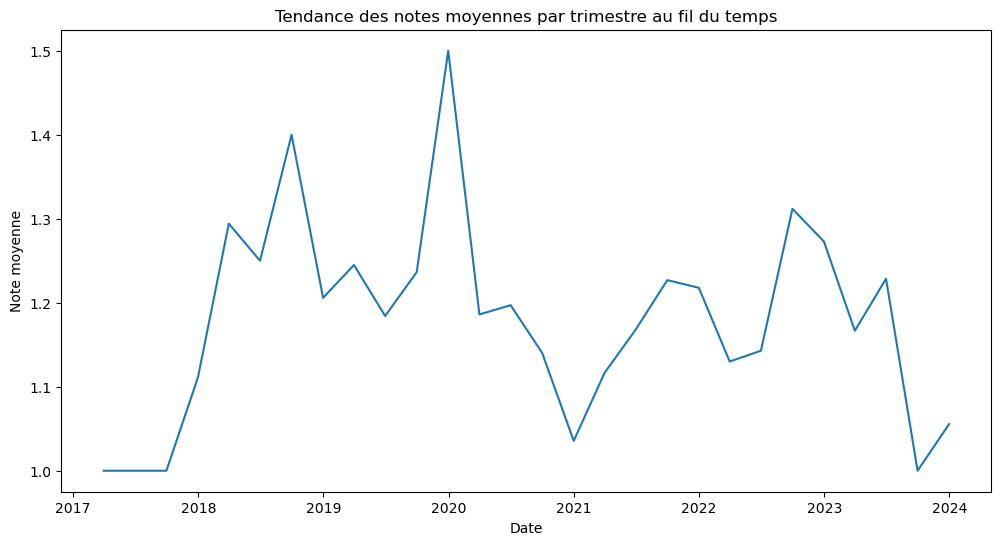

In [34]:
# Groupez les données par mois (ou trimestre) et calculez la note moyenne
monthly_data = data.resample('Q', on='Date').mean()

# Créez le graphique en courbes
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_data.index, y=monthly_data['Rating'])
plt.title('Tendance des notes moyennes par trimestre au fil du temps')
plt.xlabel('Date')
plt.ylabel('Note moyenne')
plt.show()

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Chargez vos données dans un DataFrame
data['Date'] = pd.to_datetime(data['Date'])

# Créez une fonction pour mettre à jour le graphique en fonction de la fréquence
def update_graph(freq):
    # Groupez les données par fréquence et calculez la note moyenne
    if freq == 'Mois':
        freq_code = 'M'
    elif freq == 'Trimestre':
        freq_code = 'Q'
    elif freq == 'Année':
        freq_code = 'Y'
    elif freq == 'Semaine':
        freq_code = 'W'
    else:
        freq_code = 'M'
    grouped_data = data.set_index('Date').resample(freq_code).mean()
    
    # Affichez le graphique en courbes
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=grouped_data.index, y=grouped_data['Rating'])
    plt.title(f'Tendance des notes moyennes par {freq} au fil du temps')
    plt.xlabel('Date')
    plt.ylabel('Note moyenne')
    plt.show()

# Créez une liste de fréquences pour les widgets
freqs = ['Semaine','Mois', 'Trimestre', 'Année']

# Créez un widget déroulant pour choisir la fréquence
freq_dropdown = widgets.Dropdown(options=freqs, value='Mois', description='Fréquence :')

# Utilisez la fonction interactive pour mettre à jour le graphique en fonction de la fréquence sélectionnée
interactive_plot = widgets.interactive_output(update_graph, {'freq': freq_dropdown})
display(freq_dropdown, interactive_plot)

Dropdown(description='Fréquence :', index=1, options=('Semaine', 'Mois', 'Trimestre', 'Année'), value='Mois')

Output()

# Vis : Volume des avis pour chaque catégorie / Trimestre 

<Figure size 1200x600 with 0 Axes>

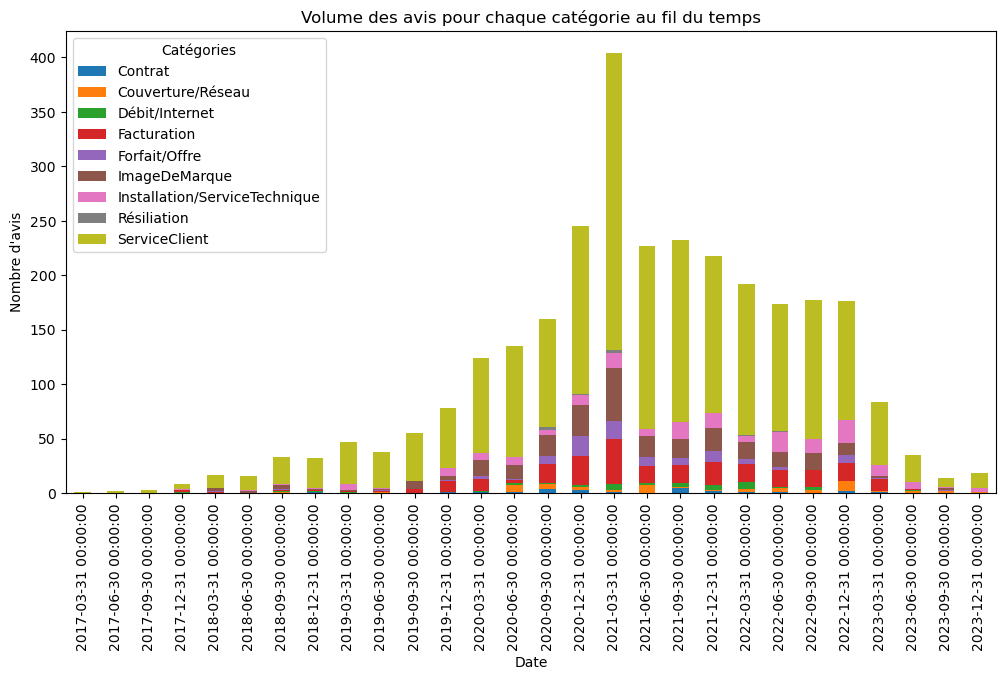

In [36]:
# Groupez les données par mois (ou trimestre) et catégorie, puis comptez le nombre d'avis
monthly_category_data = data.groupby([pd.Grouper(key='Date', freq='Q'), 'categorie1']).size().unstack()

# Créez le graphique à barres empilées
plt.figure(figsize=(12, 6))
monthly_category_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Volume des avis pour chaque catégorie au fil du temps')
plt.xlabel('Date')
plt.ylabel('Nombre d\'avis')
plt.legend(title='Catégories', loc='upper left')
plt.show()

# Vis : Volume des avis pour chaque catégorie / Trimestre 

<Figure size 1200x600 with 0 Axes>

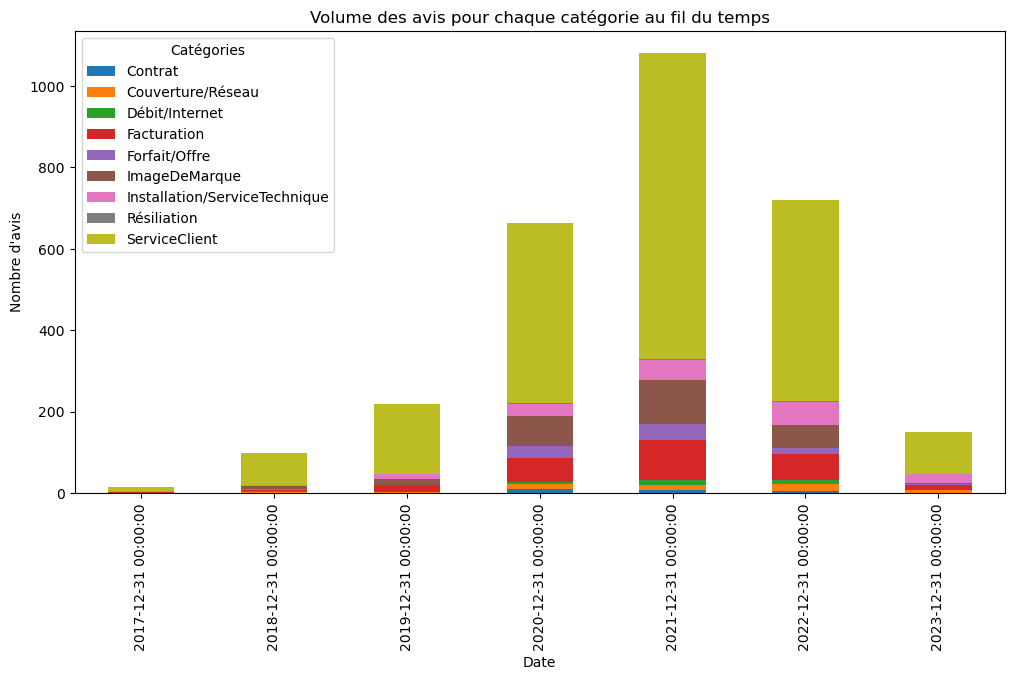

In [37]:
# Groupez les données par mois (ou trimestre) et catégorie, puis comptez le nombre d'avis
monthly_category_data = data.groupby([pd.Grouper(key='Date', freq='Y'), 'categorie1']).size().unstack()

# Créez le graphique à barres empilées
plt.figure(figsize=(12, 6))
monthly_category_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Volume des avis pour chaque catégorie au fil du temps')
plt.xlabel('Date')
plt.ylabel('Nombre d\'avis')
plt.legend(title='Catégories', loc='upper left')
plt.show()

# Vis : Note(Rating) moyenne par catégorie

In [38]:
import plotly.express as px


# Calculez le nombre d'avis et la note moyenne pour chaque catégorie
category_data = data.groupby('categorie1').agg({'Review': 'count', 'Rating': 'mean'}).reset_index()

# Créez le diagramme à bulles
fig = px.scatter(category_data,
                 x='categorie1',
                 y='Rating',
                 size='Review',
                 color='Rating',
                 color_continuous_scale='viridis',
                 labels={'categorie1': 'Catégorie', 'Rating': 'Note moyenne'},
                 title='Répartition des avis par catégorie',
                 hover_name='categorie1',
                 height=600,
                 width=900)

fig.update_xaxes(type='category')
fig.show()

# Exploration des avis par sentiment analysis

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud


def sentiment_analysis(text):
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment > 0:
        return "Positif"
    elif sentiment == 0:
        return "Neutre"
    else:
        return "Négatif"

data['Sentiment'] = data['Review'].apply(sentiment_analysis)

In [40]:
data.Rating.dtype

dtype('int64')

In [41]:
sentiment_keywords = {
            "positif": [
                "heureux","excellent", "rapide", "bon", "super", "efficace", "convivial", "aimé", "recommande", "parfait", "bonne qualité", "bon service", "prix abordable",
                "satisfait", "meilleur", "bonne couverture", "bonne connexion", "bonne assistance", "support réactif", "service clientèle compétent", "service fiable","stable","remarquable","content","aimable","fiable","flexibilité","impressionnante","impressionné","agréablement","formidable","merci","compétent","facile","soulagement","transparente","transparence","transparent"
            ],
            "négatif": [
                "incompétent","autre opérateur","Orange","voleurs","mal poli","chantage","mal","galère","pitoyable","ne recommande","désagréable","lamentable","mauvaise","insatisfaite","Déconseille","déficient","incompétent","Incapable","mépris","dégoutée","incompétent","fuyez","malhonnete","galères","honte","catastrophe","fuir","pire","mécontent","déçu", "mauvais", "lent", "cher", "coûteux", "horrible", "désagréable", "incompétent", "service médiocre", "mauvaise qualité", "mauvaise couverture",
                "a fuire","nul","mauvaise connexion", "mauvaise assistance", "service clientèle inutile", "problème", "erreur", "difficulté", "détesté", "arnaque"
                ,"sans prévenir","aucune réponse","éviter","insupportables","injoignables","injoignable","inexacte","médiocre","aucun service","malheureusement"
                ,"dommage ","effronté","sans consentement","mensonge","malhonnêteté","injoignable","escroquerie","raccroche","incompetent","lamentable","sans accord"
                ,"scandaleux","escrocs","sans consentement","inacceptable","emmerdes","surfacturation","inacceptable","désastreux","imbecile","mensonge","mensonges"
                ,"regretté","chaotique","incapables","incapable","inadmissible","minable","bye","inadmissible","consentement","surfacturation","injustifiée","déconseille"
                ,"forcée","bandits","retardé","fraudes","fraude","agressé","agression","horreur","difficile","incompétence","impossible","absurde","trompeuse","mensongère","absente"
            ]
        }
def preprocess_labels(labels_dict):
    preprocessed_labels = {}
    for key, value_list in labels_dict.items():
        preprocessed_values = [preprocess_customer_feedback(value) for value in value_list]
        preprocessed_labels[key] = preprocessed_values
    return preprocessed_labels

labels = preprocess_labels(sentiment_keywords)

def get_sentiments(row):
    text = row["Review_cleaned"]
    rating = row["Rating"]
    
    sentiment_votes = {}
    for sentiment, keywords in sentiment_keywords.items():
        for keyword in keywords:
            if keyword in text.lower():
                if sentiment in sentiment_votes:
                    sentiment_votes[sentiment] += 1
                else:
                    sentiment_votes[sentiment] = 1
    
    if sentiment_votes:
        sentiment = max(sentiment_votes, key=sentiment_votes.get)
    else:
        sentiment = "Neutre"

    if sentiment == "Positif" or rating in [4, 5]:
        return "Positif"
    elif sentiment == "Négatif" and rating in [1, 2]:
        return "Négatif"
    elif rating == 3:
        return "Neutre"
    else:
        return "Négatif"

In [42]:
data["Sentiment"] = data.apply(get_sentiments, axis=1)

In [43]:
data.head(2)

,Date,Review,Rating,Review_cleaned,categories,categorie1,categorie2,categorie3,quarter,year,Sentiment
0,2023-05-05,A FUIR !!!!!!!!!!!!!!! Très mécontente après avoir attendu 6 heures le technicien (dans un appartement loin de chez moi où je ne pouvais rien faire et ayant dû poser ma journée) personne n'est venu on m'a promis un dédommagement au téléphone et maintenant ils disent qu'il n'y a pas d'écrit et que cela fait plus de deux mois (j'ai relancé entre temps 2 fois !).... ULTRA mécontente une vraie ARNAQUE !,1,a fuir très mécontente après avoir attendu 6 heures technicien appartement loin chez où pouvais rien faire dû poser journée personne venu a promis dédommagement téléphone maintenant disent a écrit cela fait plus deux mois relancé entre temps 2 fois ultra mécontente vraie arnaque,"[Installation/ServiceTechnique, ImageDeMarque, Couverture/Réseau]",Installation/ServiceTechnique,ImageDeMarque,Couverture/Réseau,2023Q2,2023,Négatif
1,2023-05-05,Prise de rdv pour une installation fibre chez ma grand-mère. Le technicien refuse d'acheminer le câble où elle lui demande en prétextant des impossibilités techniques n'en fait qu'à sa tête et creuse un trou dans la terrasse pour faire passer le câble. Ma mère est obligée d'intervenir et lui demande de tout arrêter. Il s'en va. Nouvelle prise de rendez-vous nous demandons à changer de sous-traitant. Le rdv est pris pour un autre matin. Puis ce matin là à 9h il est déplacé pour 13h et finalement le technicien ne viendra pas. Le rendez-vous est alors reporté au lendemain après-midi et une conseillère me planifie un rdv téléphonique à la suite de ce rdv (elle ne l'a bien sûr pas honoré). Finalement c'est le même sous-traitant mais un technicien plus expérimenté. Il rebouche le trou (bien sur pas la bonne couleur). L'installation se passe bien. 1 journée et demie de perdu (= congés sans soldes) 1 terrasse détériorée. Je demande un dédommagement pour tout cela. On me propose un mois gratuit. Soit 10% de la somme que ça a engendré en frais annexe. Rien de plus à peine des excuses la conseillère absolument pas empathique ou sympathique même pas de bonne journée en fin d'appel. Évidemment pour arriver à avoir cette personne je suis passée par au moins 10 interlocuteurs. Je suis dégoutée par ce traitement. Je suis dégoutée par SFR qui impose un certains nombre d'interventions à ses sous-traitants et par conséquent qu'ils ne peuvent pas honorés leurs rendez-vous. Je suis dégoutée du mépris du 1er technicien envers ma grand-mère. Pour l'instant le téléphone ne fonctionne toujours pas car le câble tel est différent entre l'ADSL et la fibre mais ça ce n'est rien par rapport au reste...,1,prise rdv installation fibre chez grand mère technicien refuse acheminer câble où demande prétextant impossibilités techniques fait tête creuse trou terrasse faire passer câble mère obligée intervenir demande tout arrêter va nouvelle prise rendez demandons changer sous traitant rdv pris autre matin puis matin là 9h déplacé 13h finalement technicien viendra rendez alors reporté lendemain après midi conseillère planifie rdv téléphonique suite rdv a bien sûr honoré finalement sous traitant technicien plus expérimenté rebouche trou bien bonne couleur installation passe bien 1 journée demie perdu congés sans soldes 1 terrasse détériorée demande dédommagement tout cela propose mois gratuit 10 somme ça a engendré frais annexe rien plus peine excuses conseillère absolument empathique sympathique bonne journée fin appel évidemment arriver avoir cette personne passée moins 10 interlocuteurs dégoutée traitement dégoutée sfr impose certains nombre interventions sous traitants conséquent peuvent honorés leurs rendez dégoutée mépris 1er technicien envers grand mère instant téléphone fonctionne toujours car câble tel différent entre adsl fibre ça rien rapport reste,"[Installation/ServiceTechnique, ServiceClient]",Installation/ServiceTechnique,ServiceClient,None,2023Q2,2023,Négatif


In [44]:
data.to_csv('hh.csv',sep=";" , header=True, encoding='utf-8-sig')

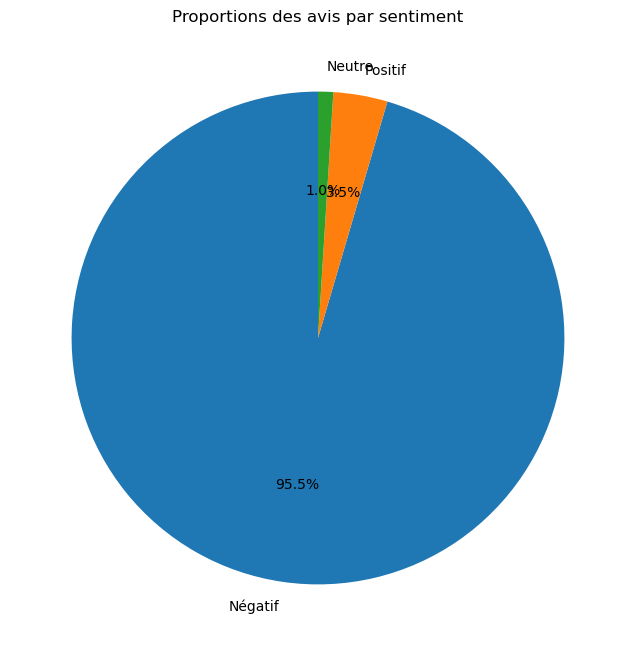

In [45]:
sentiment_counts = data['Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Proportions des avis par sentiment')
plt.ylabel('')
plt.show()

# Vis : HeatMap entre categorie1 et categorie2

In [46]:
# Calculez la note moyenne pour chaque combinaison de categorie1 et categorie2
heatmap_data = data.groupby(['categorie1', 'categorie2']).agg({'Rating': 'mean'}).reset_index()

# Transformez les données en un format adapté pour la heatmap
heatmap_data_pivot = heatmap_data.pivot_table(index='categorie1', columns='categorie2', values='Rating')

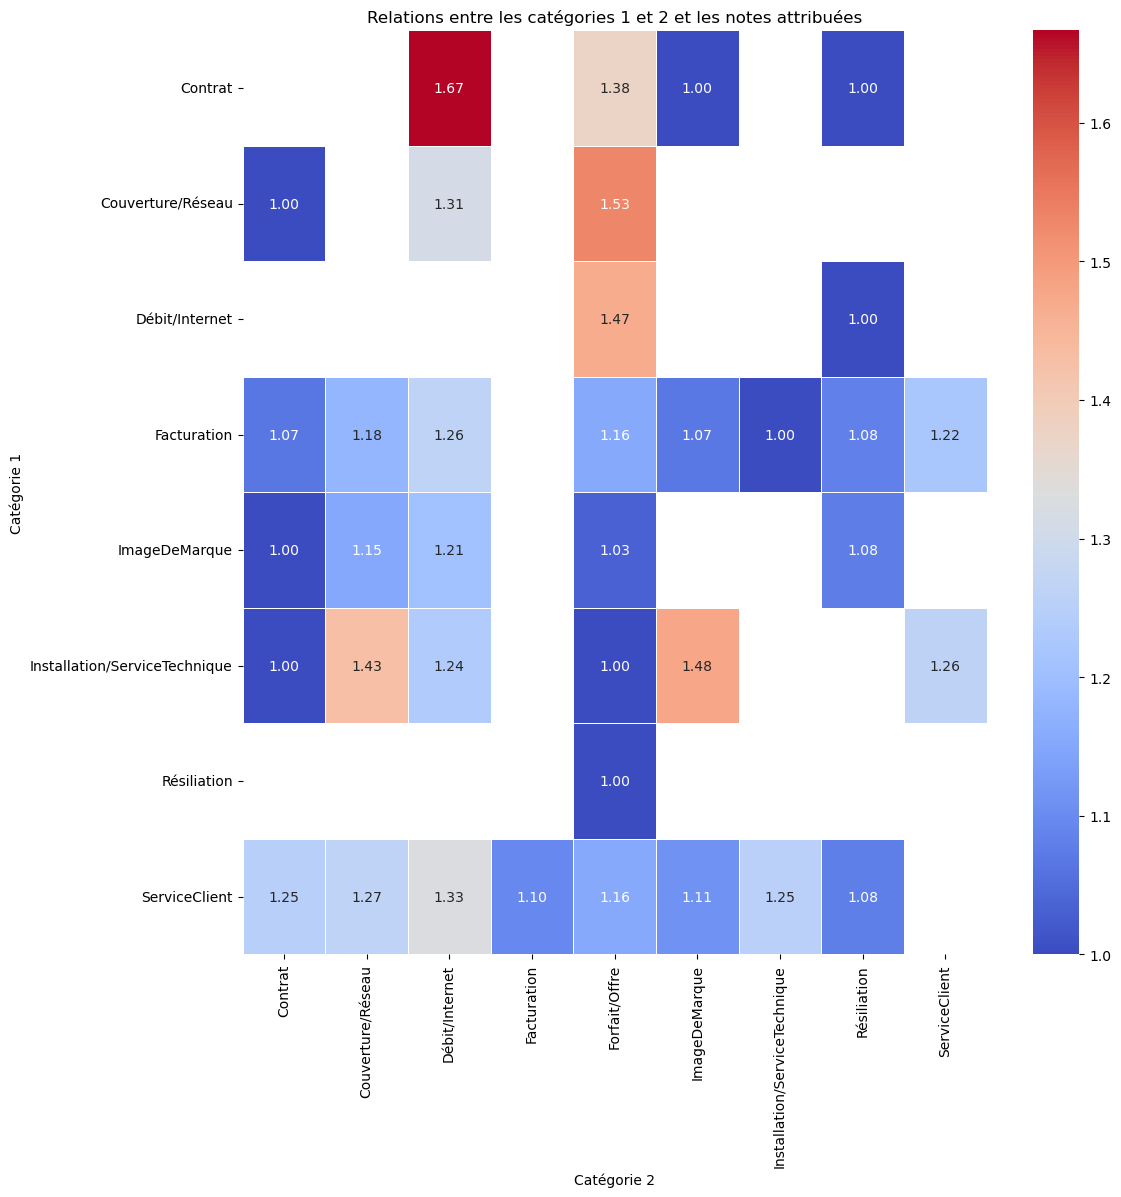

In [47]:
plt.figure(figsize=(12, 12))
sns.heatmap(heatmap_data_pivot, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Relations entre les catégories 1 et 2 et les notes attribuées')
plt.xlabel('Catégorie 2')
plt.ylabel('Catégorie 1')
plt.show()

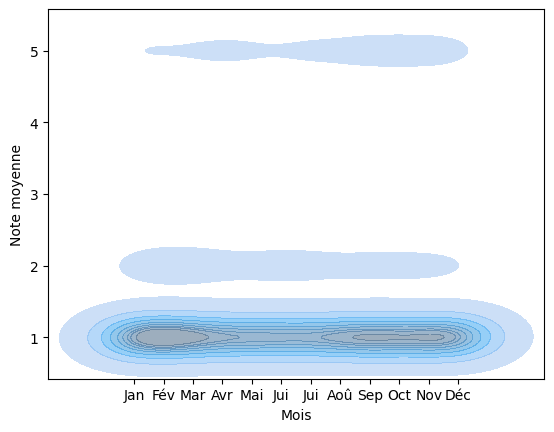

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir la colonne de dates en objet datetime
data['Date'] = pd.to_datetime(data['Date'])

# Créer une colonne "Mois" pour faciliter la visualisation
data['Mois'] = data['Date'].dt.month_name()

# Convertir les noms de mois en nombres
data['Mois_Num'] = data['Date'].dt.month

# Créer un diagramme de densité pour les notes moyennes en fonction du mois
sns.kdeplot(data=data, x="Mois_Num", y="Rating", fill=True, alpha=0.5)

# Ajouter des étiquettes d'axes personnalisées
plt.xticks(range(1, 13), labels=['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jui', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.xlabel("Mois")
plt.ylabel("Note moyenne")

# Afficher le diagramme
plt.show()

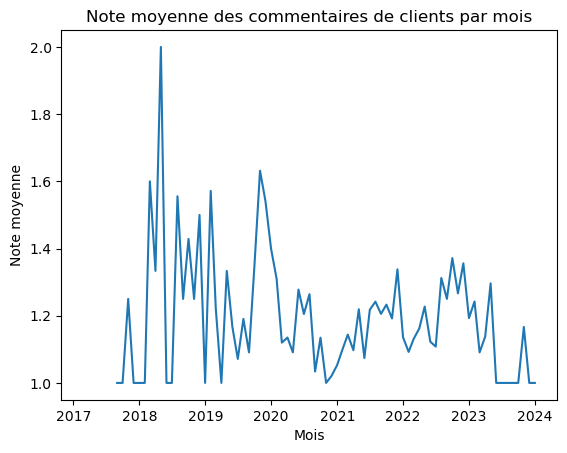

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir la colonne de dates en objet datetime et l'utiliser comme index
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Calculer la note moyenne par mois
note_moyenne_par_mois = data['Rating'].resample('M').mean()

# Tracer la série chronologique de la note moyenne
fig, ax = plt.subplots()
ax.plot(note_moyenne_par_mois.index, note_moyenne_par_mois.values)

# Ajouter des étiquettes d'axes et un titre
plt.xlabel("Mois")
plt.ylabel("Note moyenne")
plt.title("Note moyenne des commentaires de clients par mois")

# Afficher le graphique
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



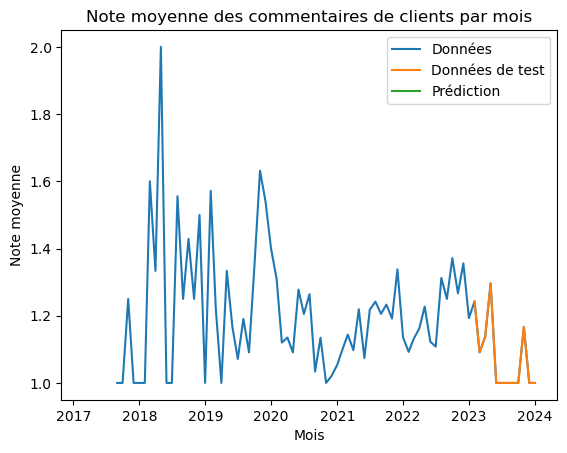

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Convertir la colonne de dates en objet datetime et l'utiliser comme index
# data['Date'] = pd.to_datetime(data['Date'])
# data = data.set_index('Date')

# Calculer la note moyenne par mois
note_moyenne_par_mois = data['Rating'].resample('M').mean()

# Diviser les données en ensembles d'entraînement et de test
train_data = note_moyenne_par_mois[:-12]
test_data = note_moyenne_par_mois[-12:]

# Créer un modèle de Holt-Winters et l'entraîner sur les données d'entraînement
model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit()

# Effectuer une prédiction pour l'année 2024
prediction = model.predict(start='2024-01-31', end='2024-12-31')

# Tracer la série chronologique de la note moyenne, avec les données de test et la prédiction
fig, ax = plt.subplots()
ax.plot(note_moyenne_par_mois.index, note_moyenne_par_mois.values, label='Données')
ax.plot(test_data.index, test_data.values, label='Données de test')
ax.plot(prediction.index, prediction.values, label='Prédiction')

# Ajouter des étiquettes d'axes et un titre
plt.xlabel("Mois")
plt.ylabel("Note moyenne")
plt.title("Note moyenne des commentaires de clients par mois")

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



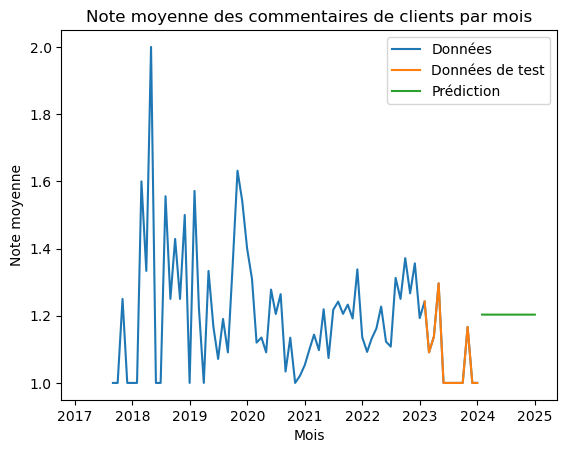

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Convertir la colonne de dates en objet datetime et l'utiliser comme index
# data['Date'] = pd.to_datetime(data['Date'])
# data = data.set_index('Date')

# Calculer la note moyenne par mois
note_moyenne_par_mois = data['Rating'].resample('M').mean()

# Diviser les données en ensembles d'entraînement et de test
train_data = note_moyenne_par_mois[:-12]
test_data = note_moyenne_par_mois[-12:]

# Créer un modèle ARIMA et l'entraîner sur les données d'entraînement
model = ARIMA(train_data, order=(2, 1, 2)).fit()

# Effectuer une prédiction pour l'année 2024
prediction = model.predict(start='2024-01-31', end='2024-12-31', typ='levels')

# Tracer la série chronologique de la note moyenne, avec les données de test et la prédiction
fig, ax = plt.subplots()
ax.plot(note_moyenne_par_mois.index, note_moyenne_par_mois.values, label='Données')
ax.plot(test_data.index, test_data.values, label='Données de test')
ax.plot(prediction.index, prediction.values, label='Prédiction')

# Ajouter des étiquettes d'axes et un titre
plt.xlabel("Mois")
plt.ylabel("Note moyenne")
plt.title("Note moyenne des commentaires de clients par mois")

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

# Automatisation ML DL

In [52]:
data['Facturation'] = [1 if 'Facturation' in i else 0 for i in data['categories']]
data['ImageDeMarque'] = [1 if 'ImageDeMarque' in i else 0 for i in data['categories']]
data['ServiceClient'] = [1 if 'ServiceClient' in i else 0 for i in data['categories']]
data['Installation/ServiceTechnique'] = [1 if 'Installation/ServiceTechnique' in i else 0 for i in data['categories']]
data['Vitesse Internet'] = [1 if 'Débit/Internet' in i else 0 for i in data['categories']]
data['Résiliation'] = [1 if 'Résiliation' in i else 0 for i in data['categories']]
data['forfait/Offre'] = [1 if 'Forfait/Offre' in i else 0 for i in data['categories']]
data['Contrat'] = [1 if 'Contrat' in i else 0 for i in data['categories']]
data['Couverture Réseau'] = [1 if 'Couverture/Réseau' in i else 0 for i in data['categories']]

In [3]:
data[data.categories == ''].shape

NameError: name 'data' is not defined

In [54]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Séparez les caractéristiques et les étiquettes
X = data['Review']
y = data[['Facturation', 'ImageDeMarque', 'ServiceClient', 'Installation/ServiceTechnique', 'Vitesse Internet', 'Résiliation', 'forfait/Offre', 'Contrat', 'Couverture Réseau']]


In [55]:
data.head(2)

,Review,Rating,Review_cleaned,categories,categorie1,categorie2,categorie3,quarter,year,Sentiment,...,Mois_Num,Facturation,ImageDeMarque,ServiceClient,Installation/ServiceTechnique,Vitesse Internet,Résiliation,forfait/Offre,Contrat,Couverture Réseau
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-05,A FUIR !!!!!!!!!!!!!!! Très mécontente après avoir attendu 6 heures le technicien (dans un appartement loin de chez moi où je ne pouvais rien faire et ayant dû poser ma journée) personne n'est venu on m'a promis un dédommagement au téléphone et maintenant ils disent qu'il n'y a pas d'écrit et que cela fait plus de deux mois (j'ai relancé entre temps 2 fois !).... ULTRA mécontente une vraie ARNAQUE !,1,a fuir très mécontente après avoir attendu 6 heures technicien appartement loin chez où pouvais rien faire dû poser journée personne venu a promis dédommagement téléphone maintenant disent a écrit cela fait plus deux mois relancé entre temps 2 fois ultra mécontente vraie arnaque,"[Installation/ServiceTechnique, ImageDeMarque, Couverture/Réseau]",Installation/ServiceTechnique,ImageDeMarque,Couverture/Réseau,2023Q2,2023,Négatif,...,5,0,1,0,1,0,0,0,0,1
2023-05-05,Prise de rdv pour une installation fibre chez ma grand-mère. Le technicien refuse d'acheminer le câble où elle lui demande en prétextant des impossibilités techniques n'en fait qu'à sa tête et creuse un trou dans la terrasse pour faire passer le câble. Ma mère est obligée d'intervenir et lui demande de tout arrêter. Il s'en va. Nouvelle prise de rendez-vous nous demandons à changer de sous-traitant. Le rdv est pris pour un autre matin. Puis ce matin là à 9h il est déplacé pour 13h et finalement le technicien ne viendra pas. Le rendez-vous est alors reporté au lendemain après-midi et une conseillère me planifie un rdv téléphonique à la suite de ce rdv (elle ne l'a bien sûr pas honoré). Finalement c'est le même sous-traitant mais un technicien plus expérimenté. Il rebouche le trou (bien sur pas la bonne couleur). L'installation se passe bien. 1 journée et demie de perdu (= congés sans soldes) 1 terrasse détériorée. Je demande un dédommagement pour tout cela. On me propose un mois gratuit. Soit 10% de la somme que ça a engendré en frais annexe. Rien de plus à peine des excuses la conseillère absolument pas empathique ou sympathique même pas de bonne journée en fin d'appel. Évidemment pour arriver à avoir cette personne je suis passée par au moins 10 interlocuteurs. Je suis dégoutée par ce traitement. Je suis dégoutée par SFR qui impose un certains nombre d'interventions à ses sous-traitants et par conséquent qu'ils ne peuvent pas honorés leurs rendez-vous. Je suis dégoutée du mépris du 1er technicien envers ma grand-mère. Pour l'instant le téléphone ne fonctionne toujours pas car le câble tel est différent entre l'ADSL et la fibre mais ça ce n'est rien par rapport au reste...,1,prise rdv installation fibre chez grand mère technicien refuse acheminer câble où demande prétextant impossibilités techniques fait tête creuse trou terrasse faire passer câble mère obligée intervenir demande tout arrêter va nouvelle prise rendez demandons changer sous traitant rdv pris autre matin puis matin là 9h déplacé 13h finalement technicien viendra rendez alors reporté lendemain après midi conseillère planifie rdv téléphonique suite rdv a bien sûr honoré finalement sous traitant technicien plus expérimenté rebouche trou bien bonne couleur installation passe bien 1 journée demie perdu congés sans soldes 1 terrasse détériorée demande dédommagement tout cela propose mois gratuit 10 somme ça a engendré frais annexe rien plus peine excuses conseillère absolument empathique sympathique bonne journée fin appel évidemment arriver avoir cette personne passée moins 10 interlocuteurs dégoutée traitement dégoutée sfr impose certains nombre interventions sous traitants conséquent peuvent honorés leurs rendez dégoutée mépris 1er technicien envers grand mère instant téléphone fonctionne toujours car câble tel différent entre adsl

In [56]:
data.to_csv("OUTPUT_0905.csv", sep=';', header = True, encoding = 'utf-8-sig')

In [57]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
from sklearn.model_selection import train_test_split

# # Créer une colonne combinant toutes les catégories
# data['combined_labels'] = data[['ImageDeMarque', 'Facturation', 'ServiceClient', 'Installation/ServiceTechnique', 'Vitesse Internet', 'Résiliation', 'forfait/Offre', 'Contrat', 'Couverture Réseau']].apply(lambda x: ''.join(x.astype(str)), axis=1)

# # Diviser les données en ensembles d'entraînement et de test en stratifiant les catégories
# X_train, X_test, y_train, y_test = train_test_split(data['Review'], data[['ImageDeMarque','Facturation', 'ServiceClient', 'Installation/ServiceTechnique', 'Vitesse Internet', 'Résiliation', 'forfait/Offre', 'Contrat', 'Couverture Réseau']], test_size=0.2, random_state=42, stratify=data['combined_labels'])

# # Supprimer la colonne 'combined_labels' du DataFrame original
# data.drop('combined_labels', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data['Review'], data[['ImageDeMarque','Facturation', 'ServiceClient', 'Installation/ServiceTechnique', 'Vitesse Internet', 'Résiliation', 'forfait/Offre', 'Contrat', 'Couverture Réseau']], test_size=0.2, random_state=42)


# Créer le pipeline de traitement des données avec la régression logistique
pipeline_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

# Créer le pipeline de traitement des données avec la forêt aléatoire
pipeline_rf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', OneVsRestClassifier(RandomForestClassifier(random_state=42)))
])

# Entraîner les modèles
pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

# Afficher les scores de classification
print("Rapport de classification pour la régression logistique :")
print(classification_report(y_test, y_pred_lr))

print("Rapport de classification pour la forêt aléatoire :")
print(classification_report(y_test, y_pred_rf))

Rapport de classification pour la régression logistique :
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       271
           1       0.76      0.50      0.60       113
           2       0.91      0.93      0.92       427
           3       0.83      0.62      0.71        92
           4       0.67      0.45      0.54       104
           5       0.44      0.24      0.31        45
           6       0.68      0.58      0.63       174
           7       0.57      0.18      0.28        22
           8       0.63      0.33      0.43        73

   micro avg       0.82      0.70      0.75      1321
   macro avg       0.71      0.52      0.59      1321
weighted avg       0.80      0.70      0.74      1321
 samples avg       0.81      0.68      0.72      1321

Rapport de classification pour la forêt aléatoire :
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       271
           1       0.7

In [58]:
import pickle

# Enregistrer le modèle
with open('model.pkl', 'wb') as file:
    pickle.dump(pipeline_lr, file)
#     ['ImageDeMarque','Facturation', 'ServiceClient', 'Installation/ServiceTechnique', 'Vitesse Internet', 'Résiliation', 'forfait/Offre', 'Contrat', 'Couverture Réseau']],

In [59]:
# Charger le modèle
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

# effectuer des prédictions sur de nouveaux échantillons
new_samples = ["Catastrophique !!! Anciennement cliente free  j’ai été séduise par la proposition de SFR   j’ai changé mobile et box . Quel regret !!! La portabilité non effectué je me suis aperçu que je payé ma box free et ma box sfr   alors que sfr s’engagé a résilier mon ancien abonnement avec frais de réalisation offert ! Pipo bref je suis déçu de sfr ils ne peuvent jamais rien faire pour vous ne trouve aucune solution . Dommage",
                "Sfr ne respecte pas les contrats. Les prix négociés en vente privée ne sont pas respectés. Malgré des courriers et mails le tarif n'a pas été respecté je n'ai jamais eu de problème avec d'autres opérateurs.",         
               "Je prends deux forfaits qui sont suspendus sans raison avec pour conséquence 5 jours ouvrés sans téléphone  est-ce pour faire fuir les clients car depuis des années avec free et orange jamais de soucis"]
predicted_labels = model.predict(new_samples)

print(predicted_labels)

[[1 0 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0]]


In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Préparation des données
X_train, X_test, y_train, y_test = train_test_split(data['Review'], data[['ImageDeMarque','Facturation', 'ServiceClient', 'Installation/ServiceTechnique', 'Vitesse Internet', 'Résiliation', 'forfait/Offre', 'Contrat', 'Couverture Réseau']], test_size=0.2, random_state=42)

# Vectorisation des données textuelles
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Binarisation des labels
mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train.values)
y_test_bin = mlb.transform(y_test.values)

# Création du modèle deep learning
model = Sequential()
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(len(vectorizer.get_feature_names()),)))
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping pour arrêter l'entraînement si la validation loss n'améliore pas
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Diviser les données d'entraînement en ensembles d'entraînement et de validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_vect.toarray(), y_train_bin, test_size=0.2, random_state=42)

# Entraînement du modèle
history = model.fit(X_train_sub, y_train_sub, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Évaluation du modèle
score = model.evaluate(X_test_vect.toarray(), y_test_bin, batch_size=64)
print("Score de test :", score)

Epoch 1/20
31/31 [==============================] - 5s 19ms/step - loss: 1.6709 - accuracy: 0.3364 - val_loss: 0.7388 - val_accuracy: 0.0083
Epoch 2/20
31/31 [==============================] - 0s 10ms/step - loss: 0.6022 - accuracy: 0.4495 - val_loss: 0.4235 - val_accuracy: 0.0828
Epoch 3/20
31/31 [==============================] - 0s 9ms/step - loss: 0.3699 - accuracy: 0.5485 - val_loss: 0.2663 - val_accuracy: 1.0000
Epoch 4/20
31/31 [==============================] - 0s 8ms/step - loss: 0.2452 - accuracy: 0.5827 - val_loss: 0.1735 - val_accuracy: 1.0000
Epoch 5/20
31/31 [==============================] - 0s 9ms/step - loss: 0.1715 - accuracy: 0.6838 - val_loss: 0.1202 - val_accuracy: 1.0000
Epoch 6/20
31/31 [==============================] - 0s 8ms/step - loss: 0.1289 - accuracy: 0.7133 - val_loss: 0.0882 - val_accuracy: 1.0000
Epoch 7/20
31/31 [==============================] - 0s 9ms/step - loss: 0.1036 - accuracy: 0.8263 - val_loss: 0.0702 - val_accuracy: 1.0000
Epoch 8/20
31/31 [

Epoch 1/20
31/31 [==============================] - 0s 12ms/step - loss: 0.0565 - accuracy: 0.9150 - val_loss: 0.0359 - val_accuracy: 1.0000
Epoch 2/20
31/31 [==============================] - 0s 9ms/step - loss: 0.0555 - accuracy: 0.9010 - val_loss: 0.0357 - val_accuracy: 1.0000
Epoch 3/20
31/31 [==============================] - 0s 8ms/step - loss: 0.0541 - accuracy: 0.9031 - val_loss: 0.0358 - val_accuracy: 1.0000
Epoch 4/20
31/31 [==============================] - 0s 8ms/step - loss: 0.0548 - accuracy: 0.9067 - val_loss: 0.0349 - val_accuracy: 1.0000
Epoch 5/20
31/31 [==============================] - 0s 8ms/step - loss: 0.0541 - accuracy: 0.9228 - val_loss: 0.0351 - val_accuracy: 1.0000
Epoch 6/20
31/31 [==============================] - 0s 9ms/step - loss: 0.0533 - accuracy: 0.9046 - val_loss: 0.0351 - val_accuracy: 1.0000
Epoch 7/20
31/31 [==============================] - 0s 9ms/step - loss: 0.0531 - accuracy: 0.9139 - val_loss: 0.0350 - val_accuracy: 1.0000


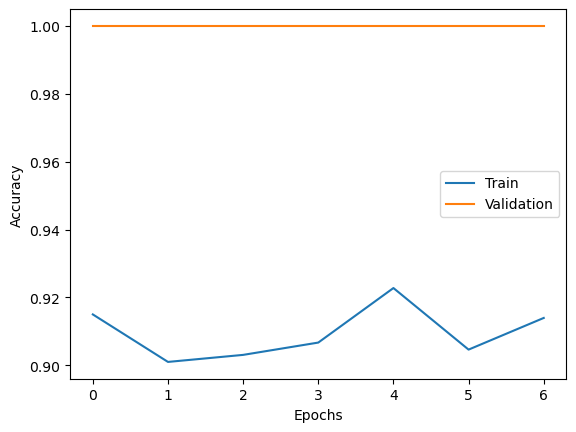

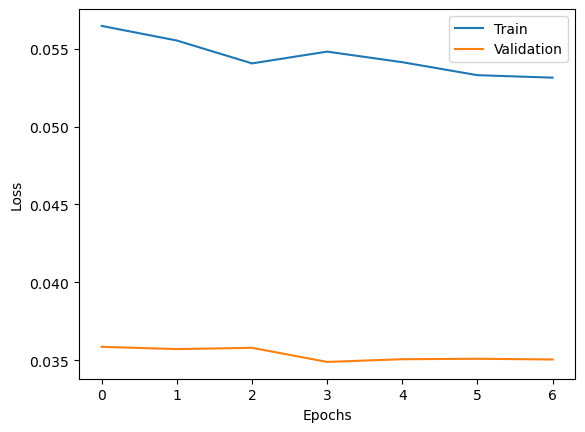

In [61]:
import matplotlib.pyplot as plt

# Entraînement du modèle et récupération de l'historique
history = model.fit(X_train_sub, y_train_sub, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Tracer la courbe d'apprentissage de la précision
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Tracer la courbe d'apprentissage de la perte
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
X_train.shape

(2412,)

# LSTMs

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Charger vos données ici (data)

# Tokenisation et séquençage
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Review'].values)
X = tokenizer.texts_to_sequences(data['Review'].values)
X = pad_sequences(X)

# Diviser les données en ensembles d'entraînement et de test
Y = data[['ImageDeMarque','Facturation', 'ServiceClient', 'Installation/ServiceTechnique', 'Vitesse Internet', 'Résiliation', 'forfait/Offre', 'Contrat', 'Couverture Réseau']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Construction du modèle LSTM
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle
batch_size = 32
epochs = 10
callbacks = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=callbacks)

# Faire des prédictions sur l'ensemble de test
Y_pred = model.predict(X_test)
Y_pred_classes = (Y_pred > 0.5).astype(int)

# Afficher les scores de classification
print(classification_report(Y_test, Y_pred_classes))

Epoch 1/10
19/61 [========>.....................] - ETA: 2:36 - loss: 0.5430 - accuracy: 0.3405

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


# Tokenization and sequencing
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Review'].values)
X = tokenizer.texts_to_sequences(data['Review'].values)
X = pad_sequences(X, maxlen=100)

# Divide data into training and test sets
Y = data[['ImageDeMarque', 'Facturation', 'ServiceClient', 'Installation/ServiceTechnique', 'Vitesse Internet', 'Résiliation', 'forfait/Offre', 'Contrat', 'Couverture Réseau']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the LSTM model
def create_model(units=196, dropout=0.2, recurrent_dropout=0.2, optimizer='adam', reg=0.0):
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.4))
    model.add(Bidirectional(LSTM(units, dropout=dropout, recurrent_dropout=recurrent_dropout, kernel_regularizer=l2(reg))))
    model.add(Dense(9, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Hyperparameter tuning using GridSearchCV
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)
param_grid = {'units': [128, 196, 256],
              'dropout': [0.2, 0.4],
              'recurrent_dropout': [0.2, 0.4],
              'optimizer': ['adam', 'RMSprop'],
              'reg': [0.0, 0.001, 0.01]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(X_train, Y_train)

# Print the best hyperparameters and accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Train the model with the best hyperparameters
best_params = grid_result.best_params_
model = create_model(units=best_params['units'], dropout=best_params['dropout'], recurrent_dropout=best_params['recurrent_dropout'], optimizer=best_params['optimizer'], reg=best_params['reg'])
callbacks = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=callbacks)

#Evaluate the model on the test data
Y_pred = model.predict(X_test)
Y_pred_classes = (Y_pred > 0.5).astype(int)

#Print the classification report
print(classification_report(Y_test, Y_pred_classes))

# BERT

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf

# Charger vos données ici (data)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data['Review'], data[['ImageDeMarque','Facturation', 'ServiceClient', 'Installation/ServiceTechnique', 'Vitesse Internet', 'Résiliation', 'forfait/Offre', 'Contrat', 'Couverture Réseau']], test_size=0.2, random_state=42)

# Préparation des données pour BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def convert_data_to_examples(train_data, test_data, train_labels, test_labels):
    train_examples = []
    for i in range(len(train_data)):
        train_examples.append(InputExample(guid=None, text_a=train_data.iloc[i], text_b=None, label=train_labels.iloc[i].tolist()))

    test_examples = []
    for i in range(len(test_data)):
        test_examples.append(InputExample(guid=None, text_a=test_data.iloc[i], text_b=None, label=test_labels.iloc[i].tolist()))

    return train_examples, test_examples

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []
    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding="max_length",
            truncation=True,
        )
        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"],
            input_dict["token_type_ids"],
            input_dict["attention_mask"],
        )
        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([None]),
        ),
    )

train_examples, test_examples = convert_data_to_examples(X_train, X_test, y_train, y_test)
train_data = convert_examples_to_tf_dataset(list(train_examples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

test_data = convert_examples_to_tf_dataset(list(test_examples), tokenizer)
test_data = test_data.batch(32)

# Construction et entraînement du modèle BERT
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.keras.metrics.BinaryAccuracy("accuracy")
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Entraîner le modèle
history = model.fit(train_data, epochs=2, validation_data=test_data)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(test_data)
y_pred_classes = (y_pred.logits > 0).astype(int)

# Afficher les scores de classification
print(classification_report(np.asarray(y_test), y_pred_classes))


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Définir les paramètres de traitement du texte
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

# Prétraiter les données de texte
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Review'])
sequences = tokenizer.texts_to_sequences(data['Review'])
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Définir les étiquettes de sortie
Y = data[['ImageDeMarque','Facturation', 'ServiceClient', 'Installation/ServiceTechnique', 'Vitesse Internet', 'Résiliation', 'forfait/Offre', 'Contrat', 'Couverture Réseau']].values

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

# Définir la taille de la couche d'embedding et la longueur maximale de la séquence
embedding_dim = 100
max_length = 1000

# Créer le modèle
model = Sequential()
model.add(Embedding(input_dim=, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

# Compiler le modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
#Hyperparameters
batch_size=64
epochs=10
lr=0.001
SEED = 5520

In [ ]:
# Model Building
def build_model():
    input_id = Input(shape=(MAX_LEN,), dtype=tf.int32)
    att_mask = Input(shape=(MAX_LEN,), dtype=tf.int32)
    token_type = Input(shape=(MAX_LEN,), dtype=tf.int32)

    embed = bert([input_id, att_mask, token_type])

    cls_output = embed[0][:, 0, :]  # embedding of the [CLS] token

    facture_out = Dropout(0.1)(cls_output)
    facture_out = Dense(1, activation='sigmoid')(facture_out)

    resil_out = Dropout(0.1)(cls_output)
    resil_out = Dense(1, activation='sigmoid')(resil_out)

    client_out = Dropout(0.1)(cls_output)
    client_out = Dense(1, activation='sigmoid')(client_out)

    tech_out = Dropout(0.1)(cls_output)
    tech_out = Dense(1, activation='sigmoid')(tech_out)

    promo_out = Dropout(0.1)(cls_output)
    promo_out = Dense(1, activation='sigmoid')(promo_out)

    internet_out = Dropout(0.1)(cls_output)
    internet_out = Dense(1, activation='sigmoid')(internet_out)

    contrat_out = Dropout(0.1)(cls_output)
    contrat_out = Dense(1, activation='sigmoid')(contrat_out)

    fibre_out = Dropout(0.1)(cls_output)
    fibre_out = Dense(1, activation='sigmoid')(fibre_out)

    couverture_out = Dropout(0.1)(cls_output)
    couverture_out = Dense(1, activation='sigmoid')(couverture_out)

    model = Model(inputs=[input_id, att_mask, token_type], outputs=[facture_out, resil_out, client_out, tech_out, promo_out, internet_out, contrat_out, fibre_out, couverture_out])
    optimizer = Adam(learning_rate=lr)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


In [ ]:
#model building
bert_model = build_model()

#model training

bert_model.fit([input_ids_train, attention_mask_train, token_type_ids_train], 
               [y_fact, y_resilience, y_client, y_tech, y_promo, y_internet, y_contrat, y_fibre, y_couverture],
               batch_size=batch_size, 
               epochs=epochs,
               validation_split=0.2)